## Bagging
- 학습 데이터를 복원추출(Bootstrap)하여 개별적으로 학습을 진행한 후 합산(Aggregate)
 - ex) 일대다 면접/채용 프로세스: 여러 명의 면접관들이 지원자를 개별적으로 평가한 후 점수를 합산
- Decision Tree 알고리즘을 이용하여 Random Forest와 유사한 모델을 구현

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('test1_modified_6.csv')

label = 'regular'
features = ['year', 'month', 'day', 'hour',
            'dayofweek', 'windforce', 'discomfort']

In [3]:
from sklearn.tree import DecisionTreeRegressor as dt

# systematic sampling -> 체계적인 샘플링(계통 추출법)
# 홀짝을 기준으로 체계적인 학습/테스트 데이터 분할 수행
train, test = df[0::2], df[1::2] # train: 짝수, test: 홀수
train, test = train.reset_index(), test.reset_index()
X_train, y_train = train[features], train[label]
X_test, y_test = test[features], test[label]

In [4]:
sampler = [1, 4556, 785, 235]
train.iloc[sampler]

,index,year,month,day,hour,dayofweek,windforce,discomfort,regular,casual,group
1,2,2017,1,1,2,6,0,0,38.0,19.0,0.0
4556,9112,2018,1,13,7,5,0,0,43.0,0.0,0.0
785,1570,2017,3,15,8,2,0,0,376.0,17.0,0.0
235,470,2017,1,29,15,6,0,0,10.0,0.0,0.0


#### List Comprehension
- append 방식에 비해 메모리를 덜 사용

In [5]:
from random import randint

In [6]:
sample_list = [randint(0, 5) for i in range(5)]
sample_list

[5, 4, 5, 3, 4]

In [7]:
train.tail()

,index,year,month,day,hour,dayofweek,windforce,discomfort,regular,casual,group
16047,32094,2021,1,31,15,6,0,0,2058.0,1376.0,72.0
16048,32096,2021,1,31,17,6,0,0,1890.0,1042.0,29.0
16049,32098,2021,1,31,19,6,0,0,1346.0,531.0,13.0
16050,32100,2021,1,31,21,6,0,0,1229.0,594.0,13.0
16051,32102,2021,1,31,23,6,0,0,496.0,192.0,6.0


In [8]:
sampler = [randint(0, len(train)-1) for i in range(len(train))]
train.iloc[sampler]

# randint를 활용하여 Bootstrap 과정을 수행 -> 학습 데이터를 복원추출
# 랜덤한 수가 뽑힐 것이고, 중복된 행이 있을 수 있음(복원추출)

,index,year,month,day,hour,dayofweek,windforce,discomfort,regular,casual,group
181,362,2017,1,15,17,6,0,0,109.0,16.0,0.0
7082,14164,2018,10,31,21,2,0,0,991.0,76.0,2.0
3162,6324,2017,9,23,5,5,0,0,132.0,47.0,0.0
5375,10750,2018,4,25,2,2,0,0,245.0,61.0,0.0
1073,2146,2017,4,7,17,4,0,0,446.0,283.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...
2630,5260,2017,8,10,23,3,0,1,268.0,62.0,1.0
2697,5394,2017,8,16,2,2,0,0,84.0,34.0,0.0
13155,26310,2020,6,20,10,5,0,1,2186.0,693.0,19.0
9858,19716,2019,8,5,11,0,0,3,1274.0,121.0,1.0


In [10]:
# Bootstrap 함수 구현

def bootstrap():
    sampler = [randint(0, len(train)-1) for i in range(len(train))]
    return train.iloc[sampler]

In [11]:
multi_df = [bootstrap() for i in range(100)]
len(multi_df)

# Bootstrap 100개가 100개의 데이터프레임에 저장된 것

100

In [12]:
# 각 df를 feature, label로 나눠서 학습하면 서로 다른 모델이 100개 생성됨
# 학습한 예측값을 리스트에 차곡차곡 쌓아서 확인

forest = []

for df in multi_df:
    X_single, y_single = df[features], df[label]
    tree = dt()
    tree.fit(X_single, y_single)
    forest.append(tree)

len(forest)

100

In [13]:
# 첫 번째 알고리즘의 테스트 데이터 예측 결과
forest[0].predict(X_test)

# forest[0], forest[1], ... 은 학습이 완료된 알고리즘이므로,
# 각각에 대한 예측값을 따로따로 도출 가능

array([  80.,   16.,   16., ..., 1702., 1401., 1070.])

In [24]:
# 각 알고리즘의 예측 결과를 하나의 데이터프레임으로 취합

opinions = pd.DataFrame()

for i, single_tree in enumerate(forest):
    opinions[str(i + 1) + '_tree'] = single_tree.predict(X_test)

opinions.head()

,1_tree,2_tree,3_tree,4_tree,5_tree,6_tree,7_tree,8_tree,9_tree,10_tree,...,91_tree,92_tree,93_tree,94_tree,95_tree,96_tree,97_tree,98_tree,99_tree,100_tree
0,80.0,34.0,33.0,38.0,46.0,53.0,34.0,31.0,38.0,46.0,...,86.0,63.0,34.0,63.0,63.0,63.0,24.0,31.0,53.0,38.0
1,16.0,15.0,33.0,20.0,18.0,44.0,16.0,29.0,16.0,16.0,...,25.0,16.0,23.0,25.0,38.0,29.0,38.0,16.0,38.0,18.0
2,16.0,4.0,33.0,20.0,18.0,44.0,16.0,32.0,18.0,32.0,...,33.0,19.0,23.0,28.0,32.0,33.0,16.0,16.0,23.0,23.0
3,34.0,24.0,54.0,27.0,34.0,74.0,24.0,24.0,24.0,23.0,...,24.0,34.0,34.0,36.0,23.0,34.0,34.0,34.0,36.0,36.0
4,45.0,54.0,54.0,45.0,45.0,74.0,54.0,54.0,45.0,47.0,...,47.0,54.0,77.0,45.0,54.0,47.0,45.0,45.0,54.0,81.0


In [26]:
# 각 tree들의 모든 결과를 합산
# 평균 계산할 때 합산 과정이 있으므로 평균만 내면 됨

opinions.T.mean()

0          51.62
1          21.25
2          20.57
3          31.86
4          51.27
          ...   
16046    1877.65
16047    1969.50
16048    1792.05
16049    1270.88
16050     879.57
Length: 16051, dtype: float64

In [27]:
y_test

# y_test 값과 예측 결과의 합산 값이 유사한 것을 확인 가능
# 이로써 Decision Tree 알고리즘을 활용하여 Random Forest와 유사한 모델을 구현했는데,
# 유사한 모델인 이유는 랜덤 포레스트 모델처럼 feature까지 모두 셔플하지는 않았기 때문

0          55.0
1          22.0
2          21.0
3          31.0
4          41.0
          ...  
16046    1937.0
16047    2135.0
16048    1586.0
16049    1298.0
16050     750.0
Name: regular, Length: 16051, dtype: float64

## MCOD
- Monte Carlo Outlier Detection
- opinions에 저장된 값을 예측값으로 저장하는게 아니라 오차값으로 저장
- 참고 자료
 - (2009) A New Strategy of Outlier Detection for QSAR/QSPR
 - 아래처럼 이상치와 normal sample을 구분하는 방식을 사용하고자 함

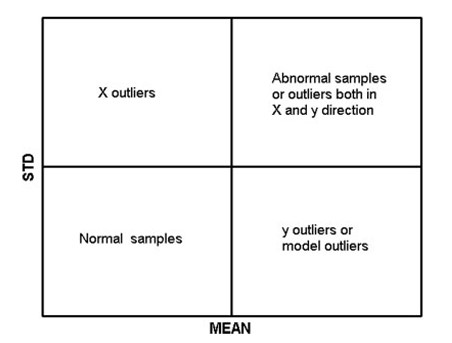

In [16]:
# 1) normal samples
# 오차의 평균과 표준편차가 모두 작은 경우
# 평균이 작다는 얘기는 오차값이 작다는 말이고,
# 표준편차가 작다는 얘기는 알고리즘이 일관적으로 예측했다는 의미

# 2) y outliers or model outliers
# 평균이 크고 표준편차가 작은 경우
# 평균이 큰데 표준편차가 작다는 것은 모델들이 일관성 있게 계속 틀린 주장을 했다는 것
# 학습 자체에 오류가 있거나 y가 이상하다고 해석

# 3) X outliers
# 평균이 작고 표준편차가 큰 경우
# feature에 이상이 있다고 해석

# 4) Abnormal samples or outliers both in X and y direction
# 평균과 표준편차가 모두 큰 경우
# X, y 모두 이상하므로 그냥 데이터 자체에 문제가 있다고 판단

In [28]:
error_forest = pd.DataFrame()

for i, single_tree in enumerate(forest):
    
    # 명확한 차이를 확인하기 위해 오차를 제곱하여 큰 오차값을 더 크게 표현
    error = (y_test - single_tree.predict(X_test)) ** 2
    error_forest[str(i + 1) + '_tree_error'] = error

error_forest.head()

# 각 행마다 알고리즘이 틀린 정도(경향성)를 보기 위해 평균과 표준편차 활용

,1_tree_error,2_tree_error,3_tree_error,4_tree_error,5_tree_error,6_tree_error,7_tree_error,8_tree_error,9_tree_error,10_tree_error,...,91_tree_error,92_tree_error,93_tree_error,94_tree_error,95_tree_error,96_tree_error,97_tree_error,98_tree_error,99_tree_error,100_tree_error
0,625.0,441.0,484.0,289.0,81.0,4.0,441.0,576.0,289.0,81.0,...,961.0,64.0,441.0,64.0,64.0,64.0,961.0,576.0,4.0,289.0
1,36.0,49.0,121.0,4.0,16.0,484.0,36.0,49.0,36.0,36.0,...,9.0,36.0,1.0,9.0,256.0,49.0,256.0,36.0,256.0,16.0
2,25.0,289.0,144.0,1.0,9.0,529.0,25.0,121.0,9.0,121.0,...,144.0,4.0,4.0,49.0,121.0,144.0,25.0,25.0,4.0,4.0
3,9.0,49.0,529.0,16.0,9.0,1849.0,49.0,49.0,49.0,64.0,...,49.0,9.0,9.0,25.0,64.0,9.0,9.0,9.0,25.0,25.0
4,16.0,169.0,169.0,16.0,16.0,1089.0,169.0,169.0,16.0,36.0,...,36.0,169.0,1296.0,16.0,169.0,36.0,16.0,16.0,169.0,1600.0


In [29]:
# 평균과 표준편차로 시각화하여 경향성을 확인
MCOD = pd.DataFrame()
MCOD['E_MEAN'] = error_forest.T.mean()
MCOD['E_STD'] = error_forest.T.std()
MCOD.head()

,E_MEAN,E_STD
0,361.68,349.012022
1,79.79,101.766349
2,62.87,103.969270
3,129.88,452.195704
4,223.37,482.598243


<AxesSubplot:xlabel='E_MEAN', ylabel='E_STD'>

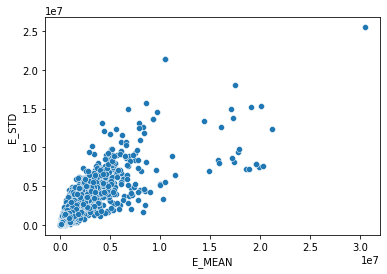

In [30]:
# 분포도 -> scatterplot
sns.scatterplot(data=MCOD, x='E_MEAN', y='E_STD')

# 오른쪽 상단에 이상치 확인 가능
# 전반적으로 데이터의 분포가 좌측 하단(normal samples)에 집중 -> 우수한 학습 수준

In [32]:
# hue 적용하기 위해 feature를 추가
MCOD[features] = test[features]
MCOD.head()

,E_MEAN,E_STD,year,month,day,hour,dayofweek,windforce,discomfort
0,361.68,349.012022,2017,1,1,1,6,0,0
1,79.79,101.766349,2017,1,1,3,6,0,0
2,62.87,103.969270,2017,1,1,5,6,0,0
3,129.88,452.195704,2017,1,1,7,6,0,0
4,223.37,482.598243,2017,1,1,9,6,0,0


<AxesSubplot:xlabel='E_MEAN', ylabel='E_STD'>

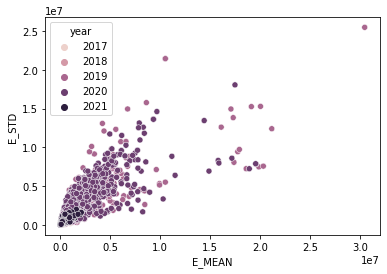

In [33]:
sns.scatterplot(data=MCOD, x='E_MEAN', y='E_STD', hue='year')

# hue=year를 적용하면 이상치가 2019년의 데이터인 것을 확인 가능